# Импорт библиотек и загрузка данных


In [2]:
!pip install catboost
!pip install xgboost
# !pip install pandas-profiling --upgrade

     |████████████████████████████████| 67.4 MB 27 kB/s 


In [3]:
import warnings
import pandas as pd
import numpy as np
# import pandas_profiling as pp

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, Ridge

from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier

from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import f_classif, mutual_info_classif

from sklearn.metrics import roc_auc_score, confusion_matrix, mean_absolute_error
from sklearn.metrics import plot_confusion_matrix, roc_curve, f1_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 42
warnings.filterwarnings("ignore")

In [4]:
X = pd.read_excel('/content/drive/MyDrive/TЗ_Будущее/x_train.xlsx')
y = pd.read_excel('/content/drive/MyDrive/TЗ_Будущее/y_train.xlsx')
# x_new = pd.read_excel('/content/drive/MyDrive/TЗ_Будущее/x_new.xlsx')

# Анализ данных

In [5]:
X.head(3)

,инвестор,пол клиента,баланс счета,возраст клиента,месяц рождения клиента,день рождения клиента,лет с заключения договора,месяцев с заключения договора,дней с заключения договора,лет на момент смерти,месяцев на момент смерти,дней на момент смерти
0,ФЛ,м,5086.37,61,6,14,14,1,31,0,0,0
1,ФЛ,м,33150.38,61,7,8,11,1,28,0,0,0
2,ФЛ,м,0.00,70,6,8,14,11,29,70,11,12


In [6]:
y.head(3)

,месяц выплаты,сумма выплаты,тип выплаты
0,8,0.00,1
1,1,0.00,1
2,11,23.44,1


In [7]:
# data = pd.concat([X, y], axis=1)
# pp_data = pp.ProfileReport(data)
# pp_data

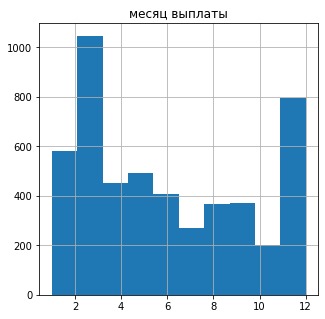

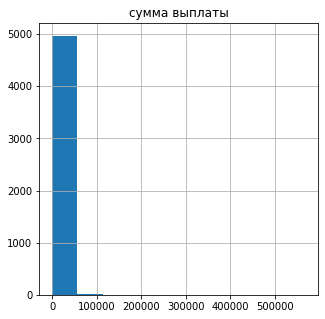

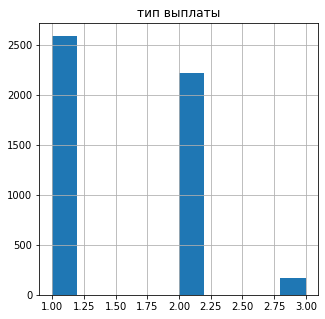

In [8]:
# Смотрим распределение таргета
y_columns = y.columns
for col in y_columns:
    plt.figure(figsize=(5, 5))
    plt.title(col)
    y[col].hist()

Сумма выплат явно растянут и имеет сильный дисбаланс. Тип выплаты - имеет сильный дисбаланс. Посмотрим на выбросы таргетов.

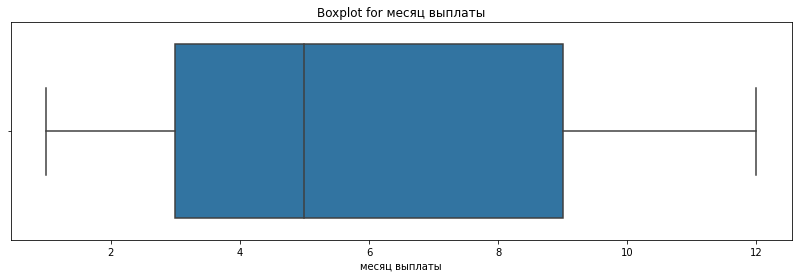

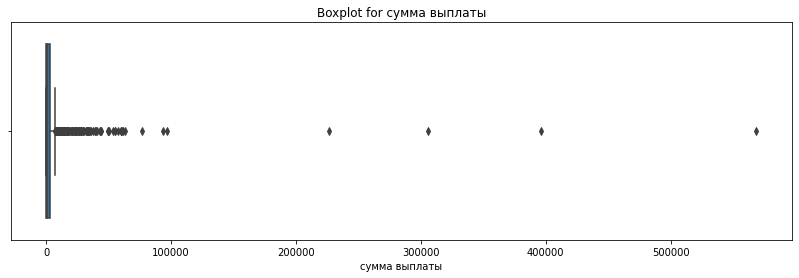

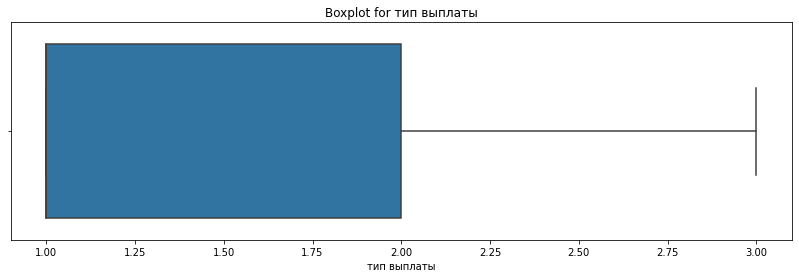

In [9]:
# Смотрим на выбросы таргетов
for col in y_columns:
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=col, data=y, ax=ax)
    plt.xticks(rotation=0)
    ax.set_title('Boxplot for ' + col)
    plt.show()

In [10]:
# pay_month = y['месяц выплаты']
# pay_month.resample('M', how='mean')
# pay_month.plot(figsize=(22,6))

## Типизация признаков 

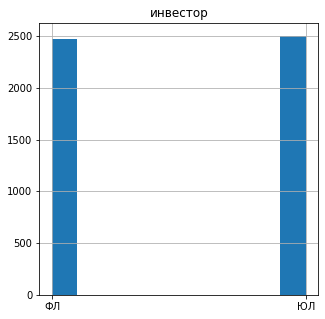

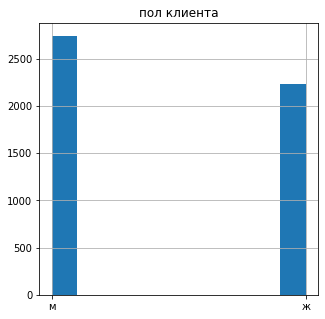

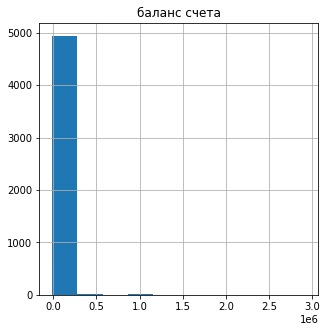

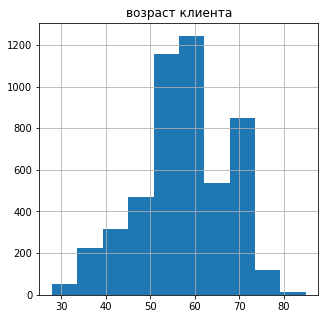

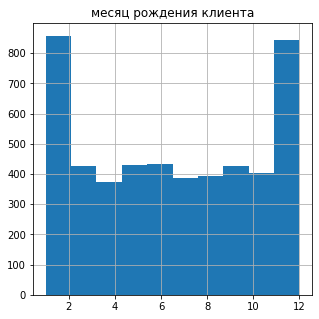

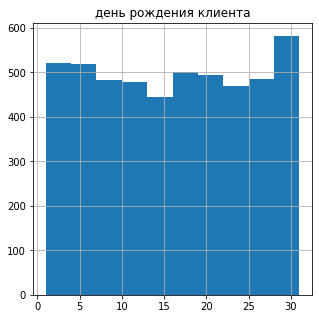

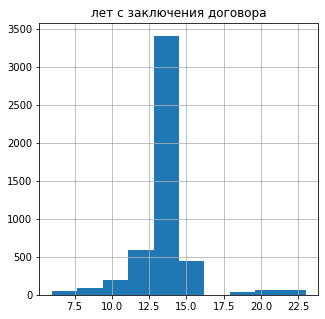

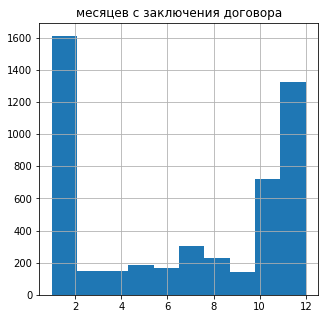

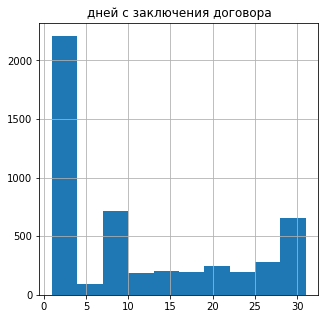

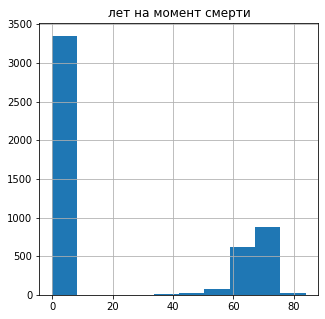

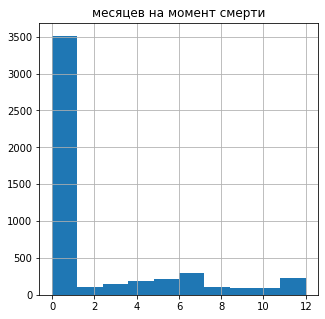

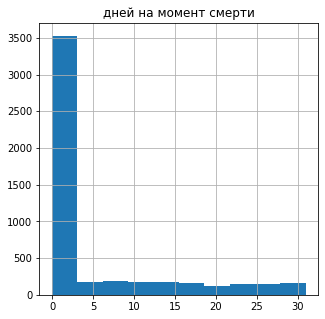

In [11]:
X_columns = X.columns
for col in X_columns:
    plt.figure(figsize=(5, 5))
    plt.title(col)
    X[col].hist()

'инвестор', 'пол клиента' это бинарные. berth_date = ['месяц рождения клиента', 'день рождения клиента', 'возраст клиента'], contract_date = ['лет с заключения договора', 'месяцев с заключения договора', 'дней с заключения договора'], dath_date = ['лет на момент смерти', 'месяцев на момент смерти', 'дней на момент смерти'] - их можно объеденить соотвественно для date_time,  'баланс cчета' - числовой признак

In [12]:
berth_date = ['день рождения клиента',
              'месяц рождения клиента', 'возраст клиента']
contr_date = ['лет с заключения договора',
              'месяцев с заключения договора', 'дней с заключения договора']
dath_date = ['лет на момент смерти',
             'месяцев на момент смерти', 'дней на момент смерти']

## Создадим новые признаки.
__________

In [13]:
# Объеденим несколько признаков во едино.
X['contract_days'] = X.apply(lambda row: row[contr_date[0]]*365 +
                             row[contr_date[1]]*30 +
                             row[contr_date[2]], axis=1)

X['live_days'] = X.apply(lambda row: row[dath_date[0]]*365 +
                         row[dath_date[1]]*30 +
                         row[dath_date[2]], axis=1)

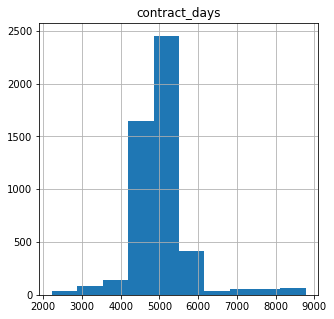

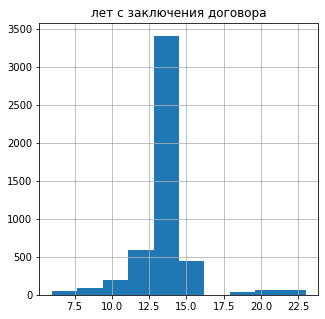

In [14]:
columns_contr = ['contract_days', 'лет с заключения договора']
for col in columns_contr:
    plt.figure(figsize=(5, 5))
    plt.title(col)
    X[col].hist()

In [15]:
# удалим лишние столбцы ['лет с заключения договора', 'месяцев с заключения договора', 'дней с заключения договора']
X.drop(contr_date, axis=1, inplace=True)

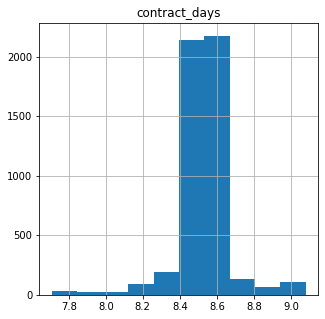

In [16]:
X['contract_days'] = np.log(X['contract_days'] + 1)
plt.figure(figsize=(5, 5))
plt.title("contract_days")
X["contract_days"].hist()

In [17]:
X['live'] = (X['live_days'] == 0).map(int)
X['have_maney'] = (X['баланс счета'] == 0).map(int)

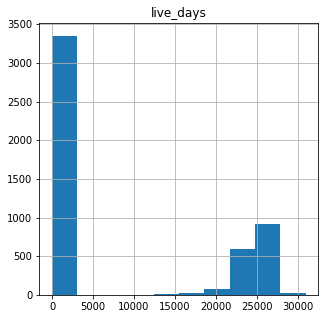

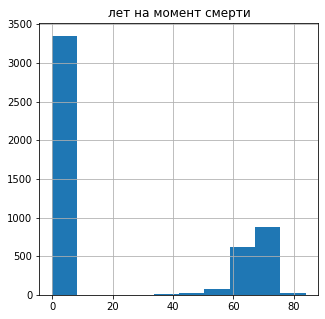

In [18]:
columns_contr = ['live_days', 'лет на момент смерти']
for col in columns_contr:
    plt.figure(figsize=(5, 5))
    plt.title(col)
    X[col].hist()

In [19]:
X.drop(dath_date, axis=1, inplace=True)

In [20]:
X.head()

,инвестор,пол клиента,баланс счета,возраст клиента,месяц рождения клиента,день рождения клиента,contract_days,live_days,live,have_maney
0,ФЛ,м,5086.37,61,6,14,8.551015,0,1,0
1,ФЛ,м,33150.38,61,7,8,8.312381,0,1,0
2,ФЛ,м,0.00,70,6,8,8.607034,25892,0,1
3,ФЛ,м,0.00,78,9,9,8.554104,28644,0,1
4,ФЛ,ж,0.00,67,6,29,8.554104,24505,0,1


In [21]:
# Отцефруем бинарные признаки
bin_cols = ['инвестор', 'пол клиента']
label_encoder = LabelEncoder()
for col in bin_cols:
    X[col] = label_encoder.fit_transform(X[col])

# Определение значимости признаков для наших таргетов.

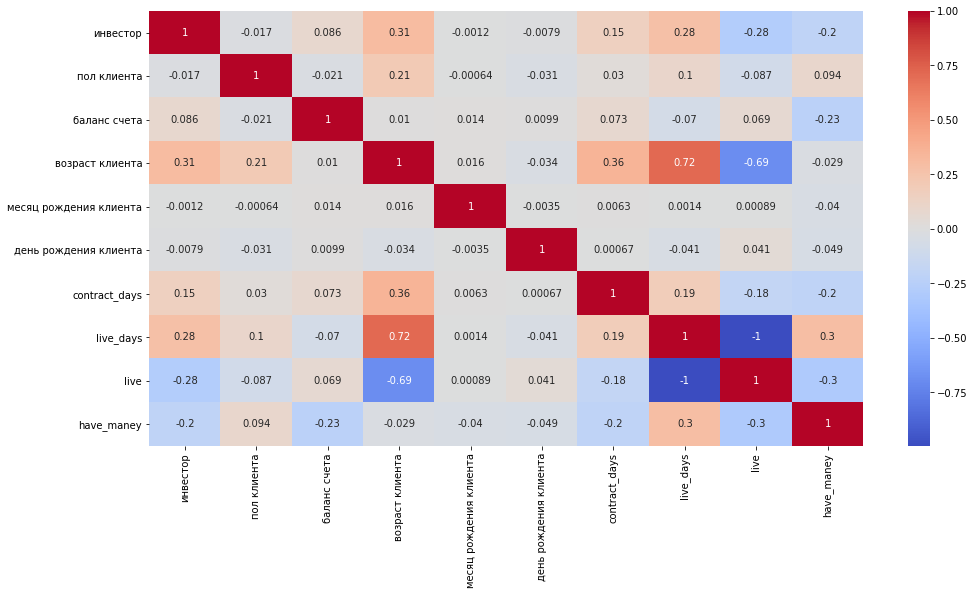

In [22]:
plt.figure(figsize=(16, 8))
sns.heatmap(X.corr(), cmap='coolwarm', annot=True)

In [23]:
# Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn.
# num_cols.remove('app_date')
# imp_num = pd.Series(f_classif(X[num_cols], df['default'])[0], index = num_cols)
# imp_num.sort_values(inplace = True)
# imp_num.plot(kind = 'barh')

In [24]:
# # Станадртизируем признаки
# from sklearn.preprocessing import StandardScaler

# std = StandardScaler()

# cols_to_std = ['contract_days', 'dath_dates']
# X_std = std.fit_transform(X[cols_to_std].values)
# X_rest = X.drop(cols_to_std, axis=1)
# X_new = np.hstack([X_std, X_rest.values])

## Прогноз "тип выплаты"

In [25]:
y_2 = y.iloc[:, 2]
X_train, X_test, y_train, y_test = train_test_split(
    X, y_2, stratify=y_2, test_size=0.2, random_state=RANDOM_SEED)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


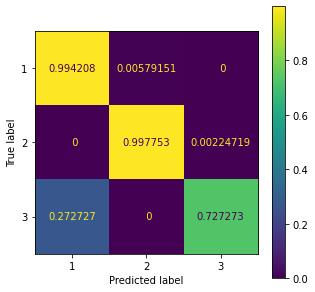

In [26]:
# Создаём модель
model_1 = RandomForestClassifier(
    n_estimators=100, max_depth=10, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
model_1.fit(X_train, y_train)
y_pred = model_1.predict(X_test)

plt.rcParams['figure.figsize'] = (5, 5)
plot_confusion_matrix(model_1, X_test, y_test,
                      values_format='3g', normalize="true")

In [27]:
f1_score(y_test, y_pred, average='micro')

0.9869477911646586

In [28]:
model_2 = CatBoostClassifier(
    iterations=1100,
    learning_rate=0.5,
    loss_function="MultiClass",
    random_state=42,
    verbose=0,
    #                           thread_count=4,
    depth=3,
    l2_leaf_reg=3.28,
)

model_2.fit(X_train, y_train,)
preds = model_2.predict(X_test)
print('f1_score:', f1_score(y_test, preds, average='micro'))

f1_score: 0.9909638554216867


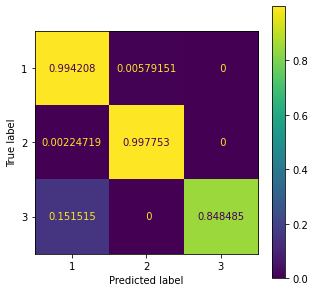

In [29]:
plt.rcParams['figure.figsize'] = (5, 5)
plot_confusion_matrix(model_2, X_test, y_test,
                      values_format='3g', normalize="true")

## Подбор гиперпараметров

In [30]:
# xgb = XGBClassifier()
# steps_float = list(np.linspace(1e-8, 1, num=10))
# params = {'n_estimators': [100, 200, 400, 500, 800, 1000], 'max_depth': [
#     3, 4, 5, 6, 7, 8, 9, 10], 'learning_rate': steps_float}
# gsc = GridSearchCV(xgb, param_grid=params, n_jobs=-1)
# gsc.fit(X_train, y_train,)

In [31]:
gsc.best_params_ # {'learning_rate': 0.11111112, 'max_depth': 3, 'n_estimators': 1000}

In [32]:
xgb = XGBClassifier(max_depth=3, n_estimators=1000, learning_rate=0.1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

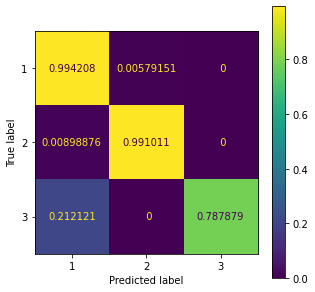

In [33]:
plt.rcParams['figure.figsize'] = (5, 5)
plot_confusion_matrix(xgb, X_test, y_test,
                      values_format='3g', normalize="true")

In [34]:
f1_score(y_test, y_pred, average='micro')

0.9859437751004017

## Прогноз месяц выплаты	

In [35]:
y_0 = y.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(
    X, y_0, stratify=y_0, test_size=0.1, random_state=RANDOM_SEED)

In [36]:
# Создаём модель
model = RandomForestClassifier(
    n_estimators=100, max_depth=10, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


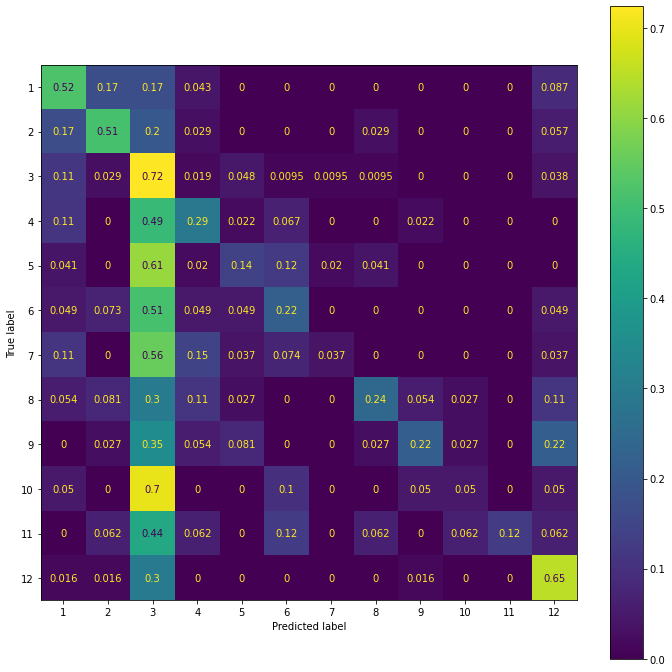

In [37]:
plt.rcParams['figure.figsize'] = (12, 12)
plot_confusion_matrix(model, X_test, y_test, normalize="true")

In [38]:
f1_score(y_test, y_pred, average='micro')

0.395582329317269

In [39]:
# добавление параметров objective="multi:softmax",  num_class=12 на качество не повлияло
xgb = XGBClassifier(max_depth=3, n_estimators=1000, learning_rate=0.1,
                    objective="multi:softmax",  num_class=12)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
f1_score(y_test, y_pred, average='micro')

0.44779116465863456

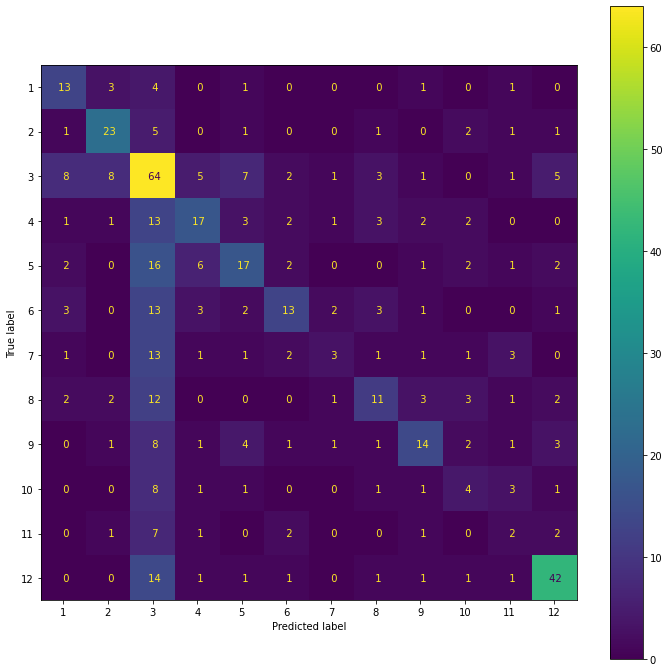

In [40]:
plot_confusion_matrix(xgb, X_test, y_test, values_format='3g')

## Прогноз "сумма выплаты"

In [41]:
X_1 = X.copy()
X_1.head(3)

,инвестор,пол клиента,баланс счета,возраст клиента,месяц рождения клиента,день рождения клиента,contract_days,live_days,live,have_maney
0,0,1,5086.37,61,6,14,8.551015,0,1,0
1,0,1,33150.38,61,7,8,8.312381,0,1,0
2,0,1,0.00,70,6,8,8.607034,25892,0,1


In [42]:
# Станадртизируем признаки
# from sklearn.preprocessing import StandardScaler

# std = StandardScaler()

# cols_to_std = ['баланс счета']
# X_std = std.fit_transform(X_1[cols_to_std])
# X_std = pd.DataFrame(data=X_std, columns=cols_to_std)
# X_rest = X_1.drop(cols_to_std, axis=1)
# X_1 = pd.concat([X_std, X_rest], axis=1)

In [43]:
# Добавим новые признаки - выполним разбение значений некоторых столбцов по 10 категорий.
X_1['contract_days_bins'] = pd.cut(X_1['contract_days'], bins=10, labels=[
                                   str(x) for x in range(1, 11)]).astype(int)
X_1['live_days_bins'] = pd.cut(X_1['баланс счета'], bins=10, labels=[
                               str(x) for x in range(1, 11)]).astype(int)

In [44]:
y_1 = y.iloc[:, 1]
X_train, X_test, y_train, y_test = train_test_split(
    X_1, y_1, test_size=0.2, random_state=RANDOM_SEED)

In [45]:
clf = Ridge(alpha=1, random_state=42)
clf.fit(X_train, np.log(y_train+1))
preds_2 = clf.predict(X_test)
# y_pred_sum = np.exp(XGBRe.predict(X_test_1))-1)
preds_2 = np.exp(clf.predict(X_test)-1)
print('MAE:', mean_absolute_error(y_test, preds_2))

MAE: 1775.1700950373731


In [46]:
xgb_params = {'n_estimators': 10000,
              'learning_rate': 0.05,
              'subsample': 0.926,
              'colsample_bytree': 0.84,
              'max_depth': 2,
              'booster': 'gbtree',
              'reg_lambda': 35.1,
              'reg_alpha': 34.9,
              'random_state': 42,
              'n_jobs': 4}
XGBRe = XGBRegressor(**xgb_params)
XGBRe.fit(X_train, np.log(y_train+1))
preds_2 = XGBRe.predict(X_test)
preds_2 = np.exp(XGBRe.predict(X_test))-1
print('MAE:', mean_absolute_error(y_test, preds_2))

[15:54:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 1556.7687240330522


# Подготвка данных x_new и предсказание лучших моделей.


In [47]:
X = pd.read_excel('/content/drive/MyDrive/TЗ_Будущее/x_train.xlsx')
y = pd.read_excel('/content/drive/MyDrive/TЗ_Будущее/y_train.xlsx')
x_new = pd.read_excel('/content/drive/MyDrive/TЗ_Будущее/x_new.xlsx')

berth_date = ['день рождения клиента',
              'месяц рождения клиента', 'возраст клиента']
contr_date = ['лет с заключения договора',
              'месяцев с заключения договора', 'дней с заключения договора']
dath_date = ['лет на момент смерти',
             'месяцев на момент смерти', 'дней на момент смерти']

In [48]:
X['Train'] = True  # помечаем где у нас трейн
x_new['Train'] = False  # помечаем где у нас тест
X = pd.concat([X, x_new], ignore_index=True)  # Объединяем

In [49]:
# Объеденим несколько признаков во едино.
X['contract_days'] = X.apply(lambda row: row[contr_date[0]]*365 +
                             row[contr_date[1]]*30 +
                             row[contr_date[2]], axis=1)

X['live_days'] = X.apply(lambda row: row[dath_date[0]]*365 +
                         row[dath_date[1]]*30 +
                         row[dath_date[2]], axis=1)

# удалим лишние столбцы ['лет с заключения договора', 'месяцев с заключения договора', 'дней с заключения договора']
X.drop(contr_date, axis=1, inplace=True)
X.drop(dath_date, axis=1, inplace=True)

X['contract_days'] = np.log(X['contract_days'] + 1)

X['live'] = (X['live_days'] == 0).map(int)
X['have_maney'] = (X['баланс счета'] == 0).map(int)

# Отцефруем бинарные признаки
bin_cols = ['инвестор', 'пол клиента']
label_encoder = LabelEncoder()
for col in bin_cols:
    X[col] = label_encoder.fit_transform(X[col])

In [50]:
X_train = X[X.Train].drop('Train', axis=1)
X_test = X[~X['Train']].drop('Train', axis=1)
y_train_type = y.iloc[:, 2]  # берем тип выплаты

# Предсказываем тип выплаты
model_2 = CatBoostClassifier(
    iterations=1100,
    learning_rate=0.5,
    loss_function="MultiClass",
    random_state=42,
    verbose=0,
    #                           thread_count=4,
    depth=3,
    l2_leaf_reg=3.28,
)

model_2.fit(X_train, y_train_type)
y_pred_type = model_2.predict(X_test)
y_pred_type = y_pred_type.flatten()

# Предсказываем месяц выплаты
y_train_month = y.iloc[:, 0]

xgb = XGBClassifier(max_depth=3, n_estimators=1000, learning_rate=0.1)
xgb.fit(X_train, y_train_month)
y_pred_month = xgb.predict(X_test)

# Предсказываем с сумму выплаты
X_1 = X.copy()

# Добавим новые признаки - выполним разбение значений некоторых столбцов по 10 категорий.
X_1['contract_days_bins'] = pd.cut(X_1['contract_days'], bins=10, labels=[
                                   str(x) for x in range(1, 11)]).astype(int)
X_1['live_days_bins'] = pd.cut(X_1['баланс счета'], bins=10, labels=[
                               str(x) for x in range(1, 11)]).astype(int)

X_train_1 = X_1[X.Train].drop('Train', axis=1)
X_test_1 = X_1[~X_1['Train']].drop('Train', axis=1)
y_train_sum = y.iloc[:, 1]  # Берем сумму выплаты

xgb_params = {'n_estimators': 10000,
              'learning_rate': 0.05,
              'subsample': 0.926,
              'colsample_bytree': 0.84,
              'max_depth': 2,
              'booster': 'gbtree',
              'reg_lambda': 35.1,
              'reg_alpha': 34.9,
              'random_state': 42,
              'n_jobs': -1}
XGBRe = XGBRegressor(**xgb_params)
XGBRe.fit(X_train_1, np.log(y_train_sum + 1))
y_pred_sum = np.exp(XGBRe.predict(X_test_1)) - 1

[16:00:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [51]:
y_new = pd.DataFrame({"месяц выплаты": y_pred_month,
                      "сумма выплаты": y_pred_sum,	"тип выплаты": y_pred_type})
y_new

,месяц выплаты,сумма выплаты,тип выплаты
0,3,453.492157,1
1,3,796.720764,2
2,4,1848.829712,2
3,3,1463.350342,2
4,3,538.125854,2
...,...,...,...
293519,9,229.062515,1
293520,5,1420.010620,1
293521,5,1501.858032,2
293522,4,786.061035,2


In [52]:
y_new.to_excel('/content/drive/MyDrive/TЗ_Будущее.y_new.xlsx')